In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os,random

本实验为李宏毅讲授的《[MLDS2018](https://docs.google.com/presentation/d/1P5ToVdC_FaFzqC-wD6al6RoLseOgzoyaYESyJasef2E/edit#slide=id.p3)》的homework3-2, 数据集使用课程使用的[数据集](https://drive.google.com/open?id=1tpW7ZVNosXsIAWu8-f5EpwtF3ls3pb79), 使用的算法采用论文《[Generative Adversarial Text to Image Synthesis](https://arxiv.org/abs/1605.05396)》中的方案

In [2]:
def load_Anime(dataset_filepath):
    tag_csv_filename = dataset_filepath.replace('images/', 'tags.csv')
    tag_dict = ['orange hair', 'white hair', 'aqua hair', 'gray hair', 'green hair', 'red hair', 'purple hair', 
            'pink hair', 'blue hair', 'black hair', 'brown hair', 'blonde hair', 
            'gray eyes', 'black eyes', 'orange eyes', 'pink eyes', 'yellow eyes',
            'aqua eyes', 'purple eyes', 'green eyes', 'brown eyes', 'red eyes', 'blue eyes']

    tag_csv = open(tag_csv_filename, 'r').readlines()

    id_label = []
    for line in tag_csv:
        id, tags = line.split(',')
        label = np.zeros(len(tag_dict))
        
        for i in range(len(tag_dict)):
            if tag_dict[i] in tags:
                label[i] = 1
        
        # Keep images with hair or eyes.
        if np.sum(label) == 2 or np.sum(label) == 1:
            id_label.append((id, label))


    # Load file name of images.
    image_file_list = []
    for image_id, _ in id_label:
        image_file_list.append(image_id + '.jpg')

    # Resize image to 64x64.
    image_height = 64
    image_width = 64
    image_channel = 3

    # Allocate memory space of images and labels.
    images = np.zeros((len(image_file_list), image_width, image_height, image_channel))
    labels = np.zeros((len(image_file_list), len(tag_dict)))
    print ('images.shape: ', images.shape)
    print ('labels.shape: ', labels.shape)


    data_dir = dataset_filepath
    for index, filename in enumerate(image_file_list):
        images[index] = cv2.cvtColor(
            cv2.resize(
                cv2.imread(os.path.join(data_dir, filename), cv2.IMREAD_COLOR), 
                (image_width, image_height)), 
                cv2.COLOR_BGR2RGB)
        labels[index] = id_label[index][1]
    
  
    np.random.seed(9487)
    indice = np.array(range(len(image_file_list)))
    np.random.shuffle(indice)
    images = images[indice]
    labels = labels[indice]

  
    # Tip 1. Normalize the inputs
    #   Normalize the images between -1 and 1.
    #   Tanh as the last layer of the generator output.
    return (images / 127.5) - 1, labels
    # return images / 255., labels

In [3]:
def lrelu(x, trainable=None):
    alpha = 0.2
    return tf.maximum(alpha*x, x)

def conv_layer(x, filter_shape, stride, trainable=True):
    filter= tf.get_variable(name='weight',
                           shape=filter_shape,
                           dtype=tf.float32,
                           initializer=tf.glorot_uniform_initializer(),
                           trainable=trainable)
    
    return tf.nn.conv2d(input=x, filter=filter,
                        strides=[1, stride, stride, 1],
                        padding='SAME')

def deconv_layer(x, filter_shape, output_shape, stride, trainable=True):
    filter = tf.get_variable(name='weight',
                            shape=filter_shape,
                            dtype=tf.float32,
                            initializer=tf.glorot_uniform_initializer(),
                            trainable=trainable)
    return tf.nn.conv2d_transpose(value=x, filter=filter,
                                 output_shape=output_shape,
                                 strides=[1, stride,stride,1])

def full_connection_layer(x, out_dim, trainable=True):
    in_dim = x.get_shape().as_list()[-1]
    weight = tf.get_variable(name='weight',
                            shape=[in_dim,out_dim],
                            dtype=tf.float32,
                            initializer=tf.glorot_normal_initializer(),
                            trainable=trainable)
    bias = tf.get_variable(name='bias',
                          shape=[out_dim],
                          dtype=tf.float32,
                          initializer=tf.constant_initializer(0.),
                          trainable=trainable)
    
    return tf.add(tf.matmul(x,weight),bias)

def flatten_layer(x):
    input_shape=x.get_shape().as_list()
    dim = input_shape[1]*input_shape[2]*input_shape[3]
    transposed = tf.transpose(x,(0,3,1,2))
    return tf.reshape(transposed,[-1,dim])

# 这里的batchnorm只是2D的形式，1D使用会出现问题
def batch_normalize(x, is_training, decay=0.99, epsilon=0.001,trainable=True):
    def bn_train():
        batch_mean,batch_var = tf.nn.moments(x, axes=[0,1,2])
        train_mean = tf.assign(pop_mean, pop_mean*decay + batch_mean*(1-decay))
        train_var  = tf.assign(pop_var, pop_var*decay + batch_var*(1-decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(x,pop_mean,pop_var,beta,scale,epsilon)
        
    
    def bn_inference():
        return tf.nn.batch_normalization(x, pop_mean,pop_var,beta, scale,epsilon)
    
    dim = x.get_shape().as_list()[-1]
    beta = tf.get_variable(name='beta',
                          shape=[dim],
                          dtype=tf.float32,
                          initializer=tf.constant_initializer(0.),
                          trainable=trainable)
    scale = tf.get_variable(name='scale',
                           shape=[dim],
                           dtype=tf.float32,
                           initializer=tf.constant_initializer(1.0),
                           trainable=trainable)
    pop_mean = tf.get_variable(name='pop_mean',
                              shape=[dim],
                              dtype=tf.float32,
                              initializer=tf.constant_initializer(0.),
                              trainable=False)
    pop_var = tf.get_variable(name='pop_var',
                             shape=[dim],
                             dtype=tf.float32,
                             initializer=tf.constant_initializer(1.0),
                             trainable=False)
    return tf.cond(is_training,bn_train,bn_inference)

In [4]:
input_width  = 64
input_height = 64

def generator(z, y, is_training, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        x = tf.concat([z,y],axis=-1)

        with tf.variable_scope('fc1'):
            fc1 = full_connection_layer(x, (input_width//16)*(input_height//16)*384)
        reshape1 = tf.reshape(fc1,[-1, input_width//16, input_height//16,384])
        with tf.variable_scope('deconv1'):
            deconv1 = deconv_layer(reshape1,[5,5,256,reshape1.get_shape().as_list()[-1]],
                               [reshape1.get_shape().as_list()[0],8,8,256],2)
            bn2 = batch_normalize(deconv1, is_training,decay=0.9, epsilon=1e-5)
            relu1 = lrelu(bn2)
        with tf.variable_scope('deconv2'):
            deconv2 = deconv_layer(relu1, [5,5,128,256],[relu1.get_shape().as_list()[0],16,16, 128],2)
            bn3 = batch_normalize(deconv2, is_training,decay=0.9, epsilon=1e-5)
            relu2 = lrelu(bn3)
        with tf.variable_scope('deconv3'):
            deconv3 = deconv_layer(relu2, [5,5,64,128],[relu2.get_shape().as_list()[0],32,32,64],2)
            bn4 = batch_normalize(deconv3, is_training,decay=0.9, epsilon=1e-5)
            relu3 = lrelu(bn4)
        with tf.variable_scope('deconv4'):
            deconv4 = deconv_layer(relu3, [5,5,3,64],[relu3.get_shape().as_list()[0],64,64,3],2)
        
        out = tf.nn.tanh(deconv4)
        
        return out
    

def discriminator(x, y, is_training, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        with tf.variable_scope('conv1'):
            conv1 = conv_layer(x, [5,5,3,64],2)
            relu1 = lrelu(conv1)
        with tf.variable_scope('conv2'):
            conv2 = conv_layer(relu1,[5,5,64,128],2)
            relu2 = lrelu(conv2)
        with tf.variable_scope('conv3'):
            conv3 = conv_layer(relu2,[5,5,128,256],2)
            relu3 = lrelu(conv3)
        with tf.variable_scope('conv4'):
            conv4 = conv_layer(relu3,[5,5,256,384],2)
            relu4 = lrelu(conv4)
        
        embed_y = tf.expand_dims(y, 1)
        embed_y = tf.expand_dims(embed_y,2)
        tiled_embeddings = tf.tile(embed_y, [1, input_width // 16, input_height // 16, 1])
        concat1 = tf.concat([relu4, tiled_embeddings], axis=-1)
        
        with tf.variable_scope('conv5'):
            conv5 = conv_layer(concat1, [1,1,concat1.get_shape().as_list()[-1],384],1)
            relu5 = lrelu(conv5)
        flatten1 = flatten_layer(relu5)
        with tf.variable_scope('fc'):
            out = full_connection_layer(flatten1,1)
        return out

In [5]:
batch_size = 128
learning_rate = 0.0001
beta1 = 0.5
beta2 = 0.9
x = tf.placeholder(tf.float32, [batch_size, 64,64,3])
y = tf.placeholder(tf.float32,[batch_size,23])
z = tf.placeholder(tf.float32,[batch_size,100])

imgs_wrong = tf.placeholder(tf.float32,[batch_size,64,64,3])
labels_wrong = tf.placeholder(tf.float32,[batch_size,23])

isTrain = tf.placeholder(tf.bool,[])

Gz = generator(z,y,isTrain)
D_fake = discriminator(Gz, y, isTrain, reuse=tf.AUTO_REUSE)

D_real = discriminator(x, y, isTrain, reuse=tf.AUTO_REUSE)

D_wrong_img = discriminator(imgs_wrong, y, isTrain, reuse=tf.AUTO_REUSE)

D_wrong_label = discriminator(x, labels_wrong, isTrain, reuse=tf.AUTO_REUSE)

d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real, labels=tf.ones_like(D_real)))
d_loss_fake = (tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.zeros_like(D_fake))) + \
              tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_wrong_img, labels=tf.zeros_like(D_wrong_img))) + \
              tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_wrong_label, labels=tf.zeros_like(D_wrong_label))) ) / 3

d_loss =  d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.ones_like(D_fake)))

d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2).minimize(d_loss, var_list=d_vars)
g_opt =  tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2).minimize(g_loss, var_list=g_vars)
        

In [6]:
train_set, train_label = load_Anime('./extra_data/extra_data/images/')

test_labels = np.zeros((batch_size, 23))
# blue hair, blue eye.
for i in range(5):
    test_labels[0 + i][8] = 1
    test_labels[0 + i][22] = 1
# blue hair, green eye.
for i in range(5):
    test_labels[5 + i][8] = 1
    test_labels[5 + i][19] = 1
# blue hair, red eye.
for i in range(5):
    test_labels[10 + i][8] = 1
    test_labels[10 + i][21] = 1
# green hair, blue eye.
for i in range(5):
    test_labels[15 + i][4] = 1
    test_labels[15 + i][22] = 1
# green hair, red eye.
for i in range(5):
    test_labels[20 + i][4] = 1
    test_labels[20 + i][21] = 1
# red hair, red eye
for i in range(5):
    test_labels[25 + i][5] = 1
    test_labels[25 + i][21] = 1
# black hair, black eyes
for i in range(5):
    test_labels[30 + i][9] = 1
    test_labels[30 + i][13] = 1
# black hair, yellow eyes
for i in range(5):
    test_labels[35 + i][9] = 1
    test_labels[35 + i][16] = 1


images.shape:  (36740, 64, 64, 3)
labels.shape:  (36740, 23)


In [7]:
def inverse_transform(images):
    return (images+1.)/2.

def save_images(images, size, epoch, image_path=None):
    gen_imgs = inverse_transform(images)
    # gen_imgs = images
    # gen_imgs should be shape (, 64, 64, 3)
    r, c = 8, 5
    fig, axs = plt.subplots(r, c,figsize=(8, 8))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,:])
            axs[i,j].axis('off')
            cnt += 1
    label = 'Epoch {0}'.format(epoch)
    fig.text(0.5, 0.04, label, ha='center')
    #fig.savefig(image_path)
    #plt.close()
    plt.show()
    
test_z_sample = np.random.normal(0, np.exp(-1 / np.pi), size=(batch_size, 100))
def visualize_results(epoch, z_sample):
    image_frame_num = 8
    image_frame_dim = 5
    samples = sess.run(Gz, 
                       feed_dict={z: z_sample, 
                                  y: test_labels,
                                  isTrain: False})

    save_images(samples[:image_frame_num * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim], epoch)

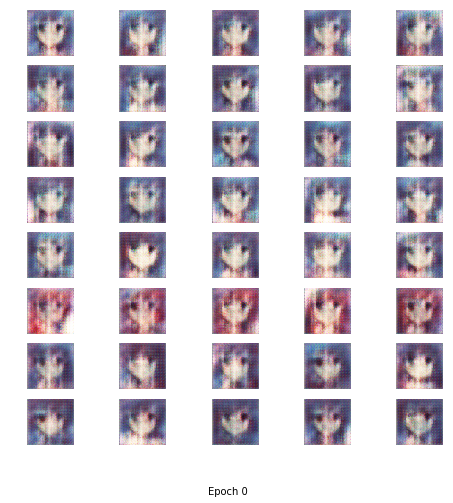

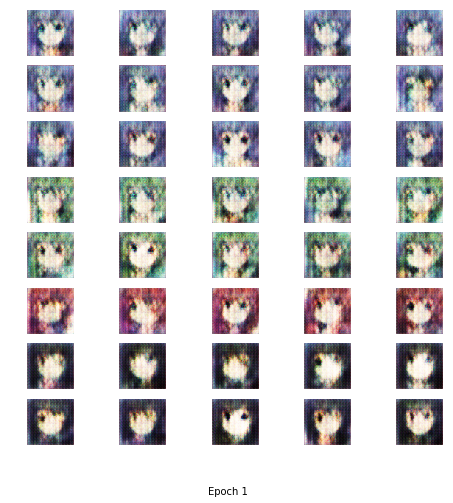

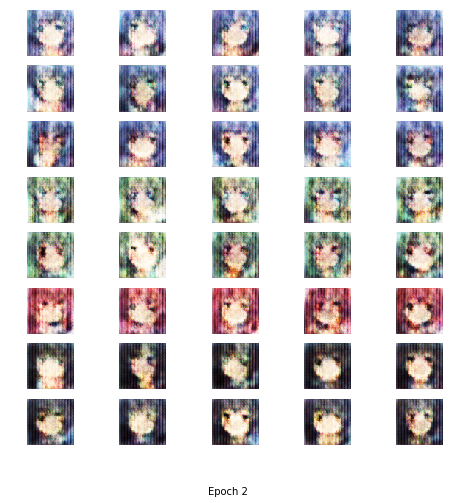

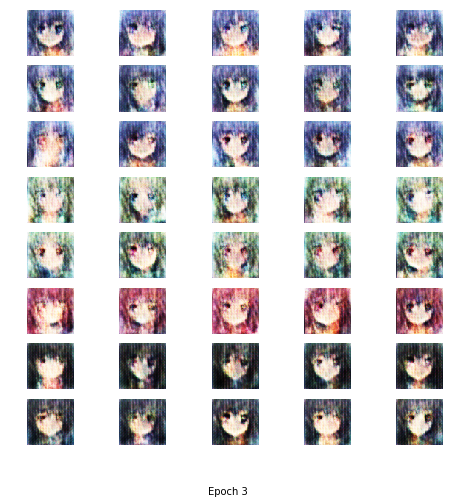

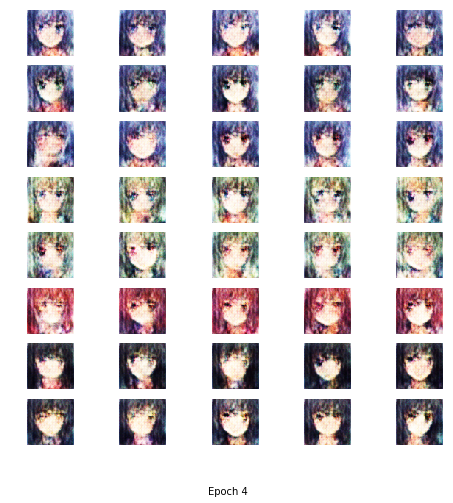

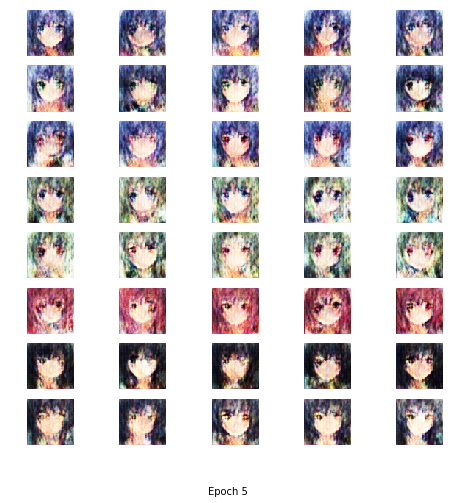

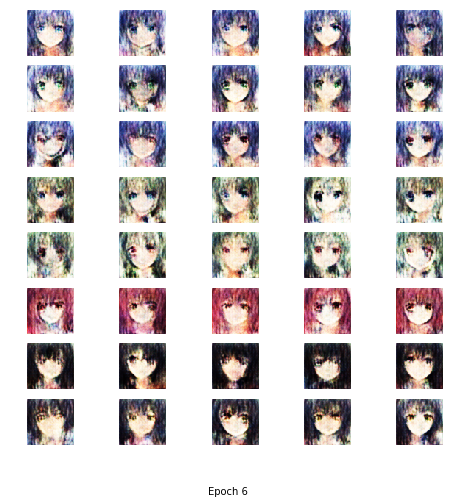

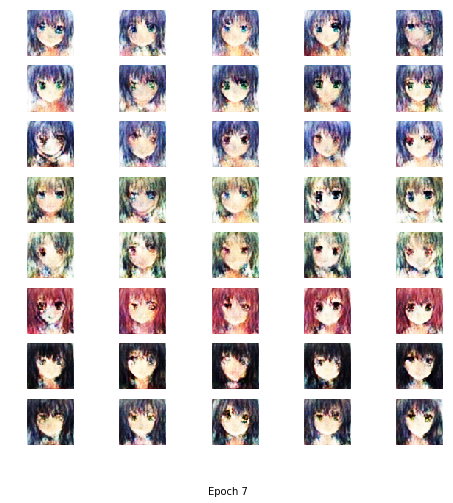

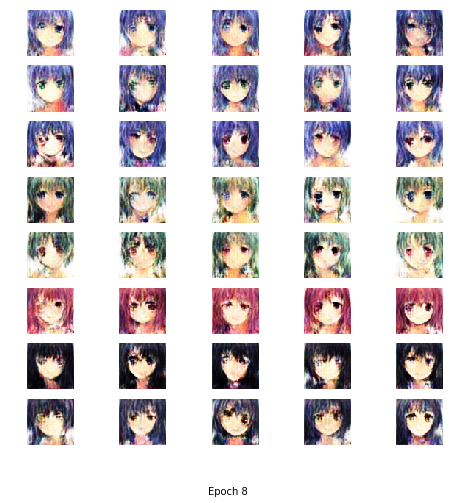

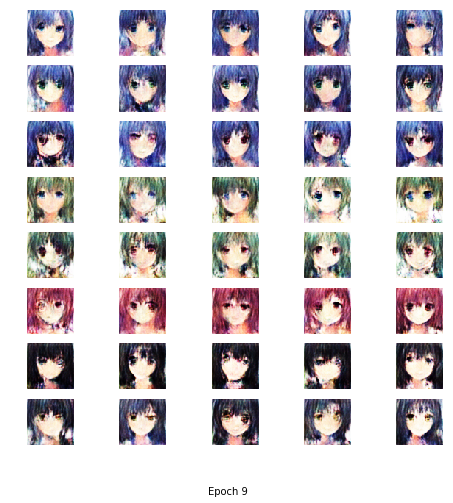

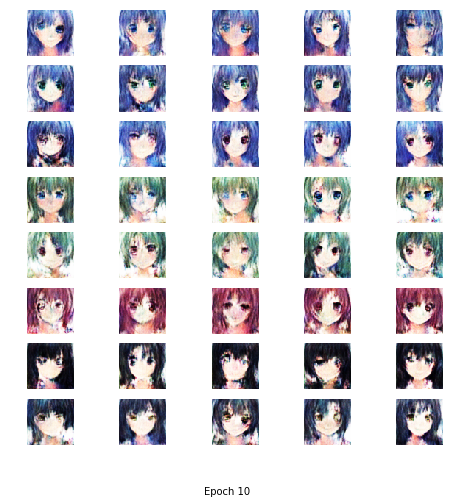

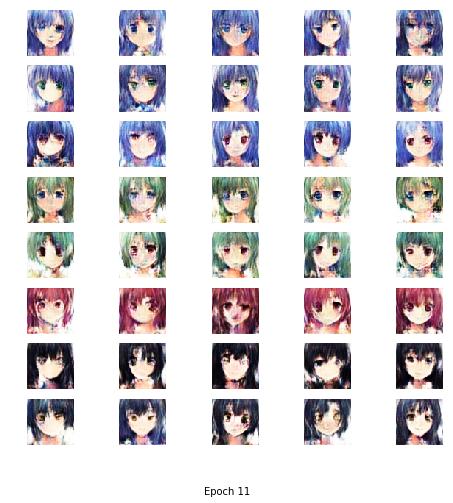

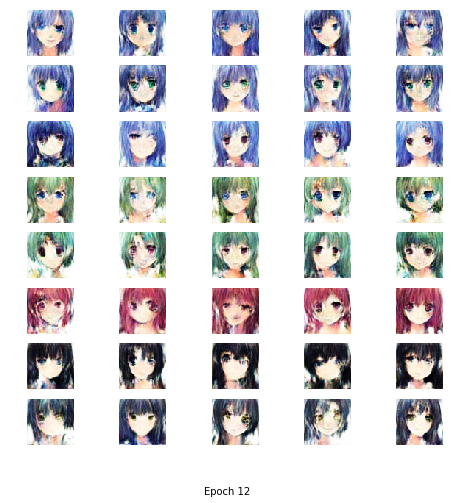

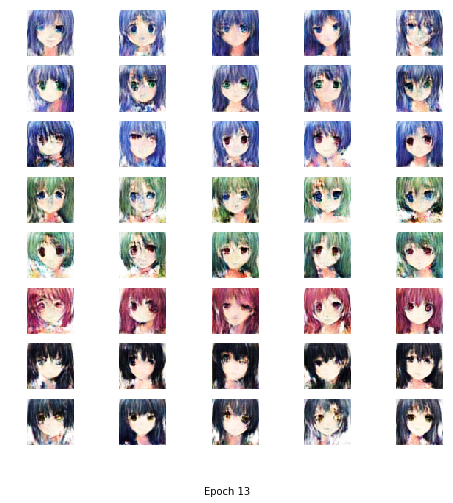

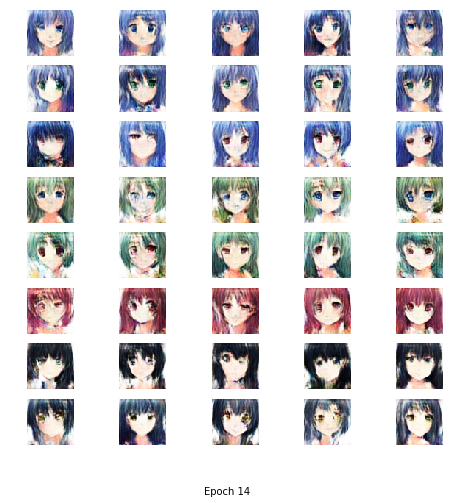

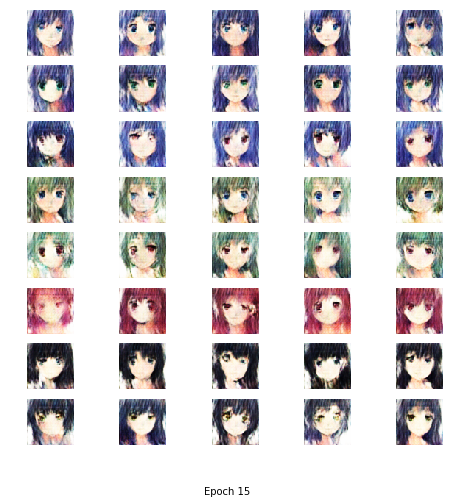

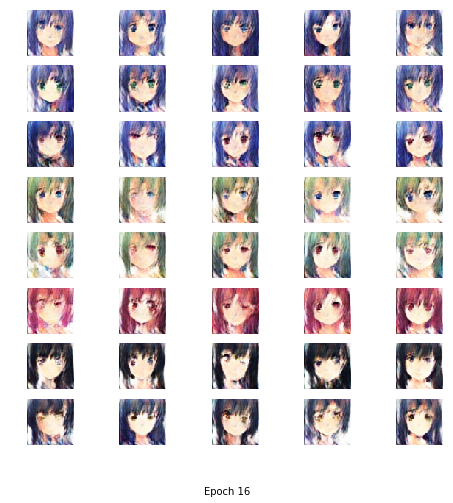

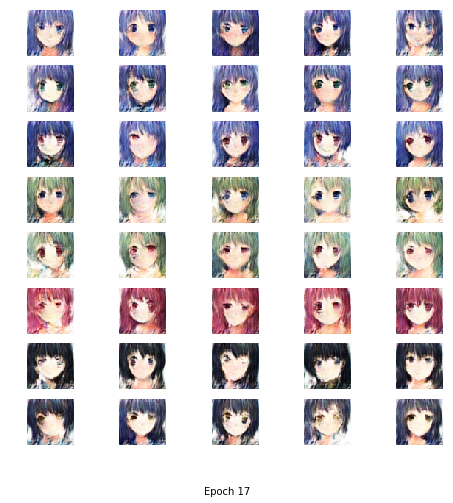

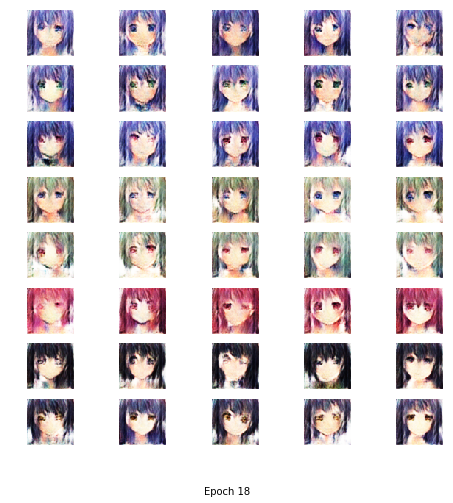

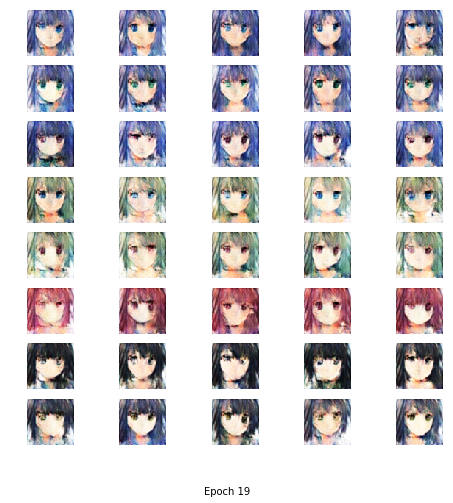

In [8]:
train_epochs = 20
d_iter = 2

gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
tf.global_variables_initializer().run()

for epoch in range(train_epochs):
    shuffle_idxs = random.sample(range(0, train_set.shape[0]), train_set.shape[0])
    shuffled_set = train_set[shuffle_idxs]
    shuffled_label = train_label[shuffle_idxs]
    for iter in range(shuffled_set.shape[0] // batch_size):
        batch_images = np.asarray(shuffled_set[iter*batch_size:(iter+1)*batch_size]).astype(np.float32)
        batch_labels = np.asarray(shuffled_label[iter*batch_size:(iter+1)*batch_size]).astype(np.float32)
        batch_images_wrong = np.asarray(shuffled_set[random.sample(range(len(shuffled_set)), len(batch_images))]).astype(np.float32)
        batch_labels_wrong = np.asarray(shuffled_label[random.sample(range(len(shuffled_label)), len(batch_images))]).astype(np.float32)
        batch_z = np.random.normal(0, np.exp(-1 / np.pi), [batch_size, 100]).astype(np.float32)
        
        for _ in range(d_iter):
            _, Dloss = sess.run([d_opt,d_loss],
                                 feed_dict={x: batch_images, 
                                            y: batch_labels, 
                                            z: batch_z, 
                                            imgs_wrong: batch_images_wrong, 
                                            labels_wrong: batch_labels_wrong,
                                            isTrain: True})
        
        batch_z = np.random.normal(0, np.exp(-1 / np.pi), [batch_size, 100]).astype(np.float32)
        _, Gloss = sess.run([g_opt, g_loss],
                             feed_dict={x: batch_images, 
                                        y: batch_labels, 
                                        z: batch_z, 
                                        imgs_wrong: batch_images_wrong, 
                                        labels_wrong: batch_labels_wrong,
                                        isTrain: True})
        
    #print("epoch: {},d_loss: {}, g_loss: {}".format(epoch,Dloss, Gloss))
    visualize_results(epoch, test_z_sample)
        